## Import necessary libraries

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, Dense, Reshape
from keras_capsnet import margin_loss, conv2d_caps, DenseCapsule, Mask, CapsuleLength
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, Dense, Reshape
from keras_capsnet import margin_loss, conv2d_caps, DenseCapsule, Mask, CapsuleLength
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from PIL import Image
from numpy import *

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import cv2

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Paramters
img_dim=(28,28,3) # Image dimensions
num_channel=3 #color channels (1=grayscales,3=RGB)
epochs=40 
batch_size=32
output_shape=20 #Number of classes

In [3]:
# Load Data
def load_ani_data():
    PATH=os.getcwd()
    data_path=PATH + '/data'
    data_dir_list=sorted(os.listdir(data_path))
    img_data_list=[]
    for dataset in data_dir_list:
        img_list=sorted(os.listdir(data_path+'/'+dataset))
        print("loaded the images of dataset -"+"{}\n".format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path+'/'+dataset+'/'+img)
            if input_img is not None:             
                input_img_resize=cv2.resize(input_img,(28,28))
                img_data_list.append(input_img_resize)        
            else:                
                print("image not loaded")                                
        img_data=np.array(img_data_list) # Convert to numpy array
        img_data=img_data.astype('float32') # Convert to float
        img_data /= 255 #Normalization 
        print(img_data.shape)
    num_of_samples =img_data.shape[0]
    
    # Assign lables to the dataset
    labels=np.ones((num_of_samples,),dtype='int64')
    labels[0:657]=0
    labels[657:1039]=1
    labels[1039:1842]=2
    labels[1842:2525]=3
    labels[2525:3089]=4
    labels[3089:3409]=5
    labels[3409:4371]=6
    labels[4371:6388]=7
    labels[6388:6713]=8
    labels[6713:7559]=9
    labels[7559:8112]=10
    labels[8112:9769]=11
    labels[9769:9991]=12
    labels[9991:10287]=13
    labels[10287:11027]=14
    labels[11027:11373]=15
    labels[11373:12234]=16
    labels[12234:13775]=17
    labels[13775:15058]=18
    labels[15058:]=19

    # Labels
    names=['Agouti','Bird_spec','Coiban_Agouti','Collared_Peccary',
           'Common_Opossum','European_Hare','Great_Tinamou','Mouflon','Ocelot','Paca',
           'Red_Brocket_Deer','Red_Deer','Red_Fox','Red_Squirrel','White-Roe_Deer',
           'Spiny_Rat','White-nosed_Coati','White_Tailed_Deer ','Wild_Boar','Wood_Mouse']
    # Convert class labels to one-hot encoding
    Y=np_utils.to_categorical(labels,output_shape)
    #Shuffle the dataset
    x,y=shuffle(img_data,Y,random_state=2) 
    #Split the dataset to train and test
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)
    return x_train, y_train, x_test, y_test

## Capsule Network 
#### The following code snipet for Capsule Network is adopted from github repo of Xifeng Guo
#### Github - https://github.com/XifengGuo/CapsNet-Keras  

In [4]:
def build_models():
    global img_dim, output_shape

    input_layer = Input(shape=(28,28,3))
    conv1 = Conv2D(filters=128, kernel_size=9, strides=1, padding='valid', activation ='relu')(input_layer)
    primary_caps = conv2d_caps(input_layer=conv1,nb_filters=32,capsule_size=8,kernel_size=9,strides=2)
    species_caps = DenseCapsule(capsule_size=16, nb_capsules=output_shape, name='densecaps')(primary_caps)
    output_layer = CapsuleLength(name='capsnet')(species_caps)

    # Decoder part..
    true_labels_input = Input(shape=(output_shape,))  # use the true label to mask the capsule
    masked_by_true_label = Mask()([species_caps, true_labels_input])  # for training process
    masked_by_max = Mask()(species_caps)  # for prediction process

    decoder = Sequential(name='decoder_out')
    decoder.add(Dense(512, activation='relu', input_dim=16*output_shape))
    decoder.add(Dense(1024, activation='relu'))
    decoder.add(Dense(np.prod(img_dim), activation='sigmoid'))
    decoder.add(Reshape(target_shape=img_dim))

    train_decoder = decoder(masked_by_true_label)
    eval_decoder = decoder(masked_by_max)

    train_model = Model(
        inputs=[input_layer, true_labels_input],
        outputs=[output_layer, train_decoder]
    )

    eval_model = Model(
        inputs=input_layer,
        outputs=[eval_decoder, output_layer]
    )

    return train_model, eval_model

In [6]:
x_train, y_train, x_test, y_test = load_ani_data()
train_model, eval_model = build_models()
print(train_model.summary())
train_model.compile(loss=[margin_loss, 'mse'], 
                    optimizer='adam',
                    loss_weights=[1.,0.392],
                    metrics={'capsnet':'accuracy'})

loaded the images of dataset -Agouti

(657, 28, 28, 3)
loaded the images of dataset -Bird_spec

(1039, 28, 28, 3)
loaded the images of dataset -Coiban_Agouti

(1842, 28, 28, 3)
loaded the images of dataset -Collared_Peccary

(2525, 28, 28, 3)
loaded the images of dataset -Common_Opossum

(3089, 28, 28, 3)
loaded the images of dataset -European_Hare

(3409, 28, 28, 3)
loaded the images of dataset -Great_Tinamou

(4371, 28, 28, 3)
loaded the images of dataset -Mouflon

(6388, 28, 28, 3)
loaded the images of dataset -Ocelot

(6713, 28, 28, 3)
loaded the images of dataset -Paca

(7559, 28, 28, 3)
loaded the images of dataset -Red_Brocket_Deer

(8112, 28, 28, 3)
loaded the images of dataset -Red_Deer

(9769, 28, 28, 3)
loaded the images of dataset -Red_Fox

(9991, 28, 28, 3)
loaded the images of dataset -Red_Squirrel

(10287, 28, 28, 3)
loaded the images of dataset -Roe_Deer

(11027, 28, 28, 3)
loaded the images of dataset -Spiny_Rat

(11373, 28, 28, 3)
loaded the images of dataset -White-n

In [7]:
def train_generator(x, y, batch_size, shift_fraction=0.1):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

In [8]:
hist=train_model.fit_generator(generator=train_generator(x_train, y_train, batch_size=batch_size,shift_fraction=0.1),
                            steps_per_epoch=int(y_train.shape[0] / batch_size),
                            epochs=epochs,
                            validation_data=[[x_test, y_test], [y_test, x_test]])

Epoch 1/40
395/395 [==============================] - 288s 729ms/step - loss: 0.5892 - capsnet_loss: 0.5746 - decoder_out_loss: 0.0374 - capsnet_acc: 0.1271 - val_loss: 0.5577 - val_capsnet_loss: 0.5443 - val_decoder_out_loss: 0.0342 - val_capsnet_acc: 0.1415
Epoch 2/40
395/395 [==============================] - 287s 726ms/step - loss: 0.5318 - capsnet_loss: 0.5203 - decoder_out_loss: 0.0293 - capsnet_acc: 0.2115 - val_loss: 0.5339 - val_capsnet_loss: 0.5200 - val_decoder_out_loss: 0.0353 - val_capsnet_acc: 0.2135
Epoch 3/40
395/395 [==============================] - 289s 731ms/step - loss: 0.5089 - capsnet_loss: 0.4990 - decoder_out_loss: 0.0253 - capsnet_acc: 0.2530 - val_loss: 0.5043 - val_capsnet_loss: 0.4942 - val_decoder_out_loss: 0.0258 - val_capsnet_acc: 0.2871
Epoch 4/40
395/395 [==============================] - 290s 734ms/step - loss: 0.4926 - capsnet_loss: 0.4839 - decoder_out_loss: 0.0223 - capsnet_acc: 0.2882 - val_loss: 0.4917 - val_capsnet_loss: 0.4819 - val_decoder_out

In [9]:
#Visualising model accuracy and loss
    
capsnet_loss=hist.history['capsnet_loss']
val_capsnet_loss=hist.history['val_capsnet_loss']
capsnet_acc=hist.history['capsnet_acc']
val_capsnet_acc=hist.history['val_capsnet_acc']
xc=range(epochs)

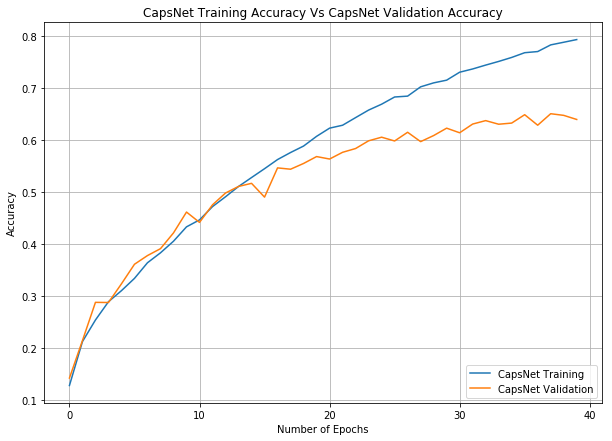

In [10]:
#Accuracy plot
plt.figure(1,figsize=(10,7))
plt.plot(xc,capsnet_acc)
plt.plot(xc,val_capsnet_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('CapsNet Training Accuracy Vs CapsNet Validation Accuracy')
plt.grid(True)
plt.legend(['CapsNet Training ','CapsNet Validation'],loc=4)
plt.style.use(['classic'])
plt.show()

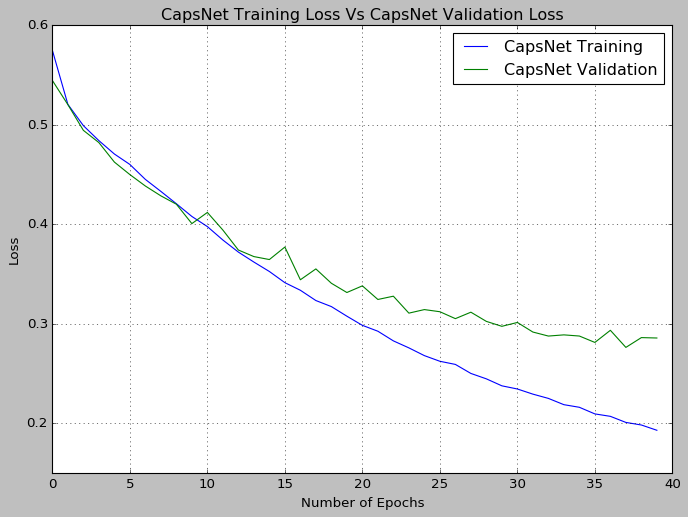

In [11]:
#Loss plot
plt.figure(2,figsize=(10,7))
plt.plot(xc,capsnet_loss) 
plt.plot(xc,val_capsnet_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('CapsNet Training Loss Vs CapsNet Validation Loss')
plt.grid(True)
plt.legend(['CapsNet Training ','CapsNet Validation'],loc=1)
plt.style.use(['classic'])
plt.show()

## Convolutional Neural Network

In [13]:
#BUILD A CNN MODEL
img_dim=(28,28,3)
num_channel=3
epochs=40
batch_size=32
output_shape=20
input_shape=(28,28,num_channel)

classifier=Sequential()
#First layer
classifier.add(Conv2D(32,(3,3),input_shape=input_shape, activation= 'relu' ))
classifier.add(MaxPooling2D(pool_size=(2,2)))
#Second layer
classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(rate=0.5))
#Third layer
classifier.add(Flatten())
classifier.add(Dense(128))
classifier.add(Activation('relu'))
classifier.add(Dropout(rate=0.5))
classifier.add(Dense(output_shape))
classifier.add(Activation('softmax'))
#Compile the model
classifier.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

In [14]:
hist_cnn=classifier.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([x_test, y_test]))

Train on 12660 samples, validate on 3166 samples
Epoch 1/40
12660/12660 [==============================] - 7s 566us/step - loss: 0.0445 - acc: 0.1695 - val_loss: 0.0435 - val_acc: 0.2006
Epoch 2/40
12660/12660 [==============================] - 7s 527us/step - loss: 0.0427 - acc: 0.2203 - val_loss: 0.0426 - val_acc: 0.2356
Epoch 3/40
12660/12660 [==============================] - 7s 533us/step - loss: 0.0418 - acc: 0.2494 - val_loss: 0.0414 - val_acc: 0.2599
Epoch 4/40
12660/12660 [==============================] - 7s 558us/step - loss: 0.0410 - acc: 0.2791 - val_loss: 0.0404 - val_acc: 0.3149
Epoch 5/40
12660/12660 [==============================] - 7s 540us/step - loss: 0.0402 - acc: 0.3066 - val_loss: 0.0391 - val_acc: 0.3301
Epoch 6/40
12660/12660 [==============================] - 7s 527us/step - loss: 0.0394 - acc: 0.3201 - val_loss: 0.0385 - val_acc: 0.3749
Epoch 7/40
12660/12660 [==============================] - 7s 525us/step - loss: 0.0387 - acc: 0.3448 - val_loss: 0.0373 - v

In [15]:
#Visualising model accuracy and loss

train_loss=hist_cnn.history['loss']
val_loss=hist_cnn.history['val_loss']
train_acc=hist_cnn.history['acc']
val_acc=hist_cnn.history['val_acc']
xc=range(epochs)

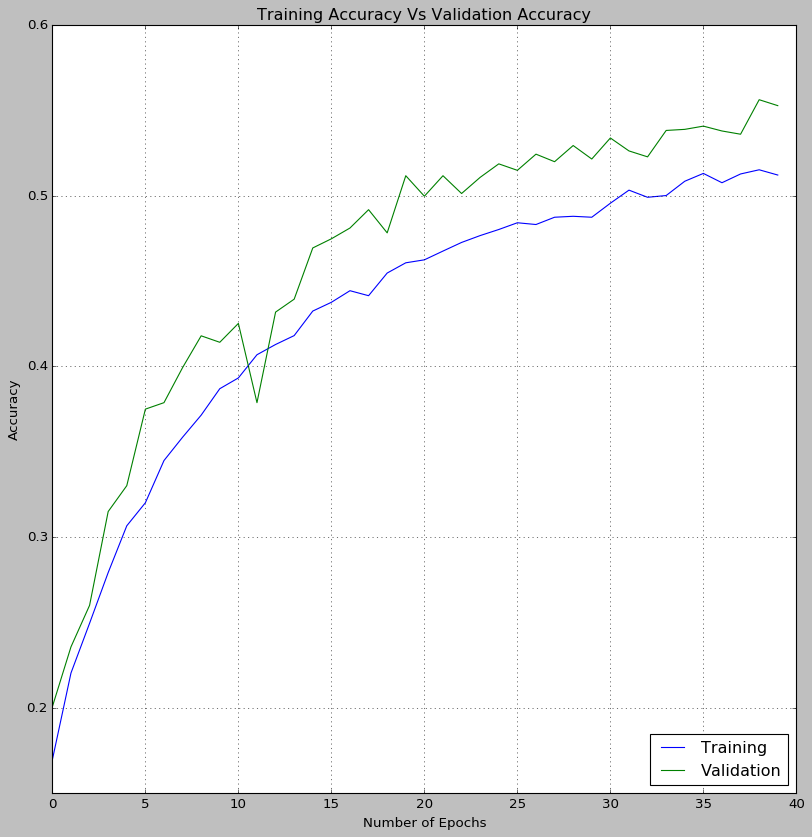

In [16]:
#Accuracy plot
plt.figure(3,figsize=(12,12))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Vs Validation Accuracy')
plt.grid(True)
plt.legend(['Training ','Validation'],loc=4)
plt.style.use(['classic'])
plt.show()

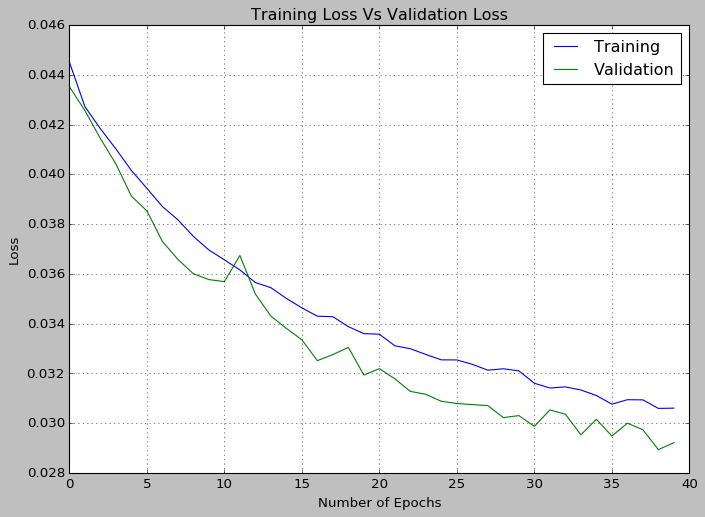

In [17]:
#Loss plot
plt.figure(4,figsize=(10,7))
plt.plot(xc,train_loss) 
plt.plot(xc,val_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Vs Validation Loss')
plt.grid(True)
plt.legend(['Training ','Validation'],loc=1)
plt.style.use(['classic'])
plt.show()

## C

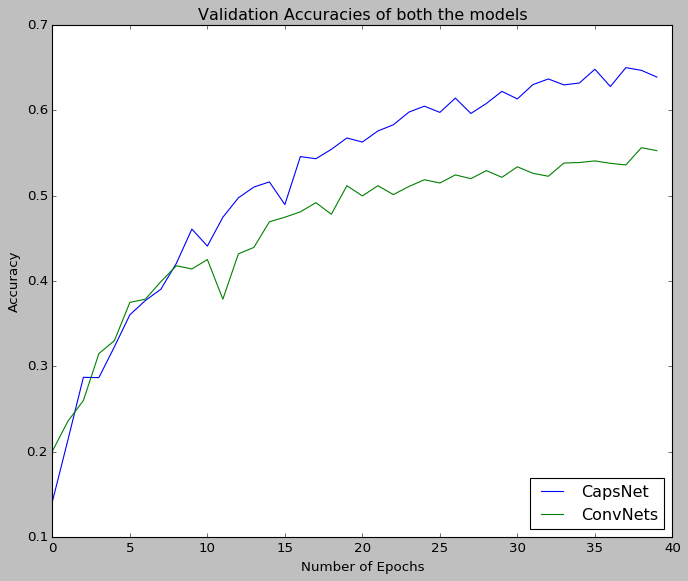

In [20]:
plt.figure(5,figsize=(10, 8))
plt.plot(xc,val_capsnet_acc)
plt.plot(xc,val_acc)
#plt.plot(hist.history['val_acc'], 'r', hist_cnn.history['val_capsnet_acc'], 'g')
plt.legend(('CapsNet','ConvNets'),loc='lower right', fontsize='large')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.title('Validation Accuracies of both the models')
plt.show()